In [3]:
# Unless otherwise instructed, you may use any functions available 
# from the following library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# An "exponentially" interesting idea...

Suppose $f(0)=3$ and $f(1)=1$ so that the secent line between these points is given by $f(x) = 3-2x$.

More generally let $f(x) = f_0-\lambda x$ and notice that $\exp(f(x)) = \exp(f_0)\exp(-\lambda x) \propto \lambda \exp(-\lambda x)$ an ***exponential distribution***, so that the area under $\exp(f(x))$ is a factor of $\frac{\exp(f_0)}{\lambda}$ times the corresponding area of the ***exponential distribution*** $\lambda \exp(-\lambda x)$; and, specifically, using the ***CDF*** of the ***exponential distribution***

$$\int_0^b \exp(f(x)) dx = \frac{\exp(f_0)}{\lambda} \times \int_0^b \lambda \exp(-\lambda x) dx = \frac{\exp(f_0)}{\lambda} \times (1 - \exp(-\lambda b))$$


For an increasing linear function, e.g., $f(0)=3$ and $f(-1)=1$ where the secent line between these points is given by $f(x) = 3+2x$ the same idea in a mirrored manner accounting for the "reverse" behavior applies.

And these right "forward" and left "backward exponentiated linear functions (proportional to ***exponential distributions***) provide a ***piecewise distribution*** that could be ***truncated***, say at $-b$ and $b$, respectively (just as an example), and sampled from by 

1. flipping a coin based on the relative areas of each of the (truncated) exponentiated distributions
2. sampling from the correspondingly selected (truncated) exponenential distribution


# Adaptive Squeezed Rejection Sampling

Update the `AdaptiveSqueezedRejectionSample` method (only, i.e., not other code should be changed) 
of the `AdaptiveSqueezedRejectionSampling` class below
so the code executes the ***(derivative-based) adaptive (squeezed) rejection sampling*** algorithm:

> 0. Given upper $up_k(x)$ and lower $lo_k(x)$ hulls of continuous piecewise linear functions which respectively 
>    - are constructed by the tangets and secants of $k$ points
>    - bound the convex log likelihood of a target distribution $f(x)$ from above and below  
>
>
> 1. Sample $x^*$ from the exponentiated upper hull (proposal distribribution) which is an unnormalized continuous density of piecewise truncated scaled exponential distributions connected end to end
>
>    1. Sample a unform random variable $u$ 
>    2. Accept the proposal $x^*$ immediately if $u < e^{lo_k(x^*)-up_k(x^*)}$, i.e., with probability $e^{lo_k(x^*)}/e^{up_k(x^*)}$ 
>    3. If $x^*$ is not accepted in previous step B, now accept proposal if $u < f(x^*)/e^{up_k(x^*)}$
>       1. Accepting $x^*$ at stage C will happen with probability $\frac{f(x^*)-e^{lo_k(x^*)}}{e^{up_k(x^*)}}$
>       2. If $x^*$ is accepted at stage C, add $x^*$ to the $k$ points defining $up_k(x)$ and $lo_k(x)$ and update the upper and lower hulls to $up_{k+1}(x)$ and $lh_{k+1}(x)$ 
> 2. If $x^*$ was not accepted in B or C above, discard $x^*$ 
>
>
> 3. Return to step 1 as desired

*This problem is inspired by sections 6.2.3.2 and 6.2.3.1 **Adaptive Rejection Sampling** and **Squeezed Rejection Sampling** on pages 158-163 in Chapter 6.2.3 **Exact Simulation: Rejection Sampling** of the Givens and Hoeting **Computational Statistics** textbook which introduce the **Adaptive Rejection Sampling** methodology that formed the basis of the first-generation universal probabilistic programming tool **WinBugs**, which (for many models) allowed users to automatically draw samples from the posterior of a Bayesian analysis based just on an initial probability model (likelihood and a prior) specification and not requiring the user to perform any of their own derivations of the posterior distribution.* 

## Hints:

- The questions below are designed to help you complete the necessary code.
    - Only update the `AdaptiveSqueezedRejectionSample` method.  
    - Nothing else in the `AdaptiveSqueezedRejectionSampling` class and related code should be changed.
    
    
- Why doesn't, e.g., `ASRS.UpperHull(support)` appear to match it's defined fucntion signature `def UpperHull(self, x):`?
    - Because `self` automatically assumes the value `ASRS` when the `UpperHull` method is called from the `ASRS` object.


- When in a class object, the object may call it's own methods and attributes as, e.g., 
    - `self.target(self.xk[i])`
    - `self.SampleFromIntervals(self.SampleUpperHullIntervals(n))`
    - `self.AdaptiveSqueezedRejectionSample()`    


In [4]:
class AdaptiveSqueezedRejectionSampling(object):

    def __init__(self, target, logpdf, scoref, xk):
        self.target, self.logpdf, self.scoref = target, logpdf, scoref
        self.xk,self.zk = np.array([]),np.array([])
        self.Adapt(list(xk))

    def UpperHull(self, x):
        @np.vectorize
        def _UpperHull(x):
            i = np.sum(x > self.zk)
            return self.logpdf(self.xk[i]) + (x-self.xk[i])*self.scoref(self.xk[i])
        return _UpperHull(x)
    
    def LowerHull(self, x):
        @np.vectorize
        def _LowerHull(x):
            if x<self.xk[0] or x>self.xk[-1]:
                return -np.Inf
            else:
                i = np.sum(x > self.xk)-1
                return ((self.xk[i+1]-x)*self.logpdf(self.xk[i]) + 
                        (x-self.xk[i])*self.logpdf(self.xk[i+1]))/(self.xk[i+1]-self.xk[i])
        return _LowerHull(x)

    def ExponentiatedUpperHullIntervalAreas(self):
        p = 0*self.xk
        for i in range(len(self.xk)):
            if i == 0:
                a, b = -np.Inf, self.zk[i]
            elif i == (len(self.xk)-1):
                a, b = self.zk[i-1], np.Inf
            else:
                a, b = self.zk[i-1], self.zk[i]
            p[i] = self.target(self.xk[i])*np.exp(-self.xk[i]*self.scoref(self.xk[i]))
            p[i] = p[i]*( np.exp(self.scoref(self.xk[i])*b) -
                          np.exp(self.scoref(self.xk[i])*a) )/self.scoref(self.xk[i])
        return p

    def SampleUpperHullIntervals(self, n):
        p = self.ExponentiatedUpperHullIntervalAreas()
        return np.argmax(stats.multinomial.rvs(1, p/p.sum(), size=n), axis=1)

    def SampleFromExponentiatedUpperHullIntervals(self, i):
        @np.vectorize
        def _SampleFromExponentiatedUpperHullInterval(i):
            if i == 0:
                return self.zk[i] - stats.expon(scale=1/self.scoref(self.xk[i])).rvs(size=1)[0]
            elif i == len(self.xk)-1:
                return self.zk[i-1] + stats.expon(scale=-1/self.scoref(self.xk[i])).rvs(size=1)[0]
            elif self.scoref(self.xk[i]) < 0:
                return self.zk[i-1] + \
                       stats.truncexpon(scale=-1/self.scoref(self.xk[i]), 
                                        b=-(self.zk[i]-self.zk[i-1])*self.scoref(self.xk[i])).rvs(size=1)[0]
            else:
                return self.zk[i] - \
                       stats.truncexpon(scale=1/self.scoref(self.xk[i]), 
                                        b=(self.zk[i]-self.zk[i-1])*self.scoref(self.xk[i])).rvs(size=1)[0]
        return _SampleFromExponentiatedUpperHullInterval(i)

    def SampleFromPiecewiseExponentiatedUpperHull(self, n):
        return self.SampleFromExponentiatedUpperHullIntervals(self.SampleUpperHullIntervals(n))

    def AdaptiveSqueezedRejectionSample(self):
        x = stats.uniform.rvs(size=1) # wrong
        u = stats.uniform.rvs(size=1)
        if u < x: # wrong
            return x
        elif u < x**0.5: # wrong
            # self.Adapt(...) missing
            return x
        else:
            return self.AdaptiveSqueezedRejectionSample()
                
    def Adapt(self, xk):
        self.xk = np.sort(xk)
        self.zk = (self.logpdf(self.xk[1:]) - self.logpdf(self.xk[:-1]) - 
                   self.xk[1:]*self.scoref(self.xk[1:]) + self.xk[:-1]*self.scoref(self.xk[:-1])) 
        self.zk = self.zk / (self.scoref(self.xk[:-1])-self.scoref(self.xk[1:]))

### Problem 2 question 0-11 (2 points, 1/6 point each)

0. What argument(s) needs to be passed to the `Adapt` method when called as a method?

- (A) `self`
- (B) `xk`
- (C) `self` and `xk`
- (D) None of the above

1. The `k` on the `xk` parameter of the `Adapt` method refers to what?

- (A) The $k^{th}$ elment of `x`, i.e., `k` refers to an index
- (B) The number of samples created thus far by the A(S)RS algorithm
- (C) The number of points used to construct the upper and lower hulls
- (D) It doesn't refer to anything -- it's just an arbitrary parameter name

2. What input should be given to the `Adapt` method?

- (A) `int`
- (B) `list`
- (C) `str`
- (D) `lambda x: ...`

3. There are three possible outcomes in the `AdaptiveSqueezedRejectionSample` method. The last one in the `else` clause caputes which of the following cases?

- (A) The proposal `x` was accepted with probability equal to the ratio of the upper and lower hulls $e^{lo_k(x^*)-up_k(x^*)}$
- (B) The proposal `x` was accepted with probability $\frac{f(x^*)-e^{lo_k(x^*)}}{e^{up_k(x^*)}}$
- (C) The proposal `x` was not accepted with probability $\frac{e^{up_k(x^*)} - f(x^*)}{e^{up_k(x^*)}}$
- (D) None of the above

4. There are three possible outcomes in the `AdaptiveSqueezedRejectionSample` method. The second one in the `elif` clause caputes which of the following cases where the `self.Adapt` method needs to be called?

- (A) The proposal `x` was accepted with probability equal to the ratio of the upper and lower hulls $e^{lo_k(x^*)-up_k(x^*)}$
- (B) The proposal `x` was accepted with probability $\frac{f(x^*)-e^{lo_k(x^*)}}{e^{up_k(x^*)}}$
- (C) The proposal `x` was not accepted with probability $\frac{e^{up_k(x^*)} - f(x^*)}{e^{up_k(x^*)}}$
- (D) None of the above

5. There are three possible outcomes in the `AdaptiveSqueezedRejectionSample` method. The first one in the `if` clause caputes which of the following cases?

- (A) The proposal `x` was accepted with probability equal to the ratio of the upper and lower hulls $e^{lo_k(x^*)-up_k(x^*)}$
- (B) The proposal `x` was accepted with probability $\frac{f(x^*)-e^{lo_k(x^*)}}{e^{up_k(x^*)}}$
- (C) The proposal `x` was not accepted with probability $\frac{e^{up_k(x^*)} - f(x^*)}{e^{up_k(x^*)}}$
- (D) None of the above

6. Which of the following funtions is $up_k$? 

- (A) `self.LowerHull`
- (B) `self.UpperHull`
- (C) `self.target`
- (D) `self.scoref`

7. Which of the following funtions is $lo_k$? 

- (A) `self.LowerHull`
- (B) `self.UpperHull`
- (C) `self.target`
- (D) `self.scoref`

8. Which of the following funtions is $f$? 

- (A) `self.LowerHull`
- (B) `self.UpperHull`
- (C) `self.target`
- (D) `self.scoref`

9. What does `x = self.SampleFromExponentiatedUpperHullIntervals(self.SampleUpperHullIntervals(1))[0]` do?

- (A) It draws a piecewise segment of $uh_k$ proportionally to the areas of the segments which comprise $uh_k$
- (B) It samples from the (exponential or truncated exponential) distribution which the selected piecewise segment is
- (C) It draws sample proportionally from $uh_k$ so that it functions as a probability density function proposal distribution
- (D) All of the above

10. Why must the density be log concave?
- (A) This is explicitly referencing the fact that all densities are either log concave or log convex
- (B) So that the log likelihood can be computed efficiently and can be optimized through maximization
- (C) So that the tangents of upper hull and the secants of the lower hull create an envolope around $f$
- (D) It does not need to be log concave for the Adaptive Squeezed Rejection Sampling algorithm to work

11. How many points are used to construct the upper and lower hulls once the `AdaptiveSqueezedRejectionSample` method is fixed and the code above is run?


In [ ]:
# p2q0-q10: 1/6 point each [format: `str` either "A" or "B" or "C" or "D" based on the choices above]
p2q0 = ""#<"A"|"B"|"C"|"D"> 
p2q1 = ""#<"A"|"B"|"C"|"D"> 
p2q2 = ""#<"A"|"B"|"C"|"D"> 
p2q3 = ""#<"A"|"B"|"C"|"D"> 
p2q4 = ""#<"A"|"B"|"C"|"D"> 
p2q5 = ""#<"A"|"B"|"C"|"D"> 
p2q6 = ""#<"A"|"B"|"C"|"D"> 
p2q7 = ""#<"A"|"B"|"C"|"D"> 
p2q8 = ""#<"A"|"B"|"C"|"D"> 
p2q9 = ""#<"A"|"B"|"C"|"D"> 
p2q10 = ""#<"A"|"B"|"C"|"D"> 
# p2q11: [format: `int`]
p2q11 = #
# This cell will produce a runtime error until the `p1q11` variable is assigned a value

In [5]:
class AdaptiveSqueezedRejectionSampling(object):

    def __init__(self, target, logpdf, scoref, xk):
        self.target, self.logpdf, self.scoref = target, logpdf, scoref
        self.xk,self.zk = np.array([]),np.array([])
        self.Adapt(list(xk))

    def UpperHull(self, x):
        @np.vectorize
        def _UpperHull(x):
            i = np.sum(x > self.zk)
            return self.logpdf(self.xk[i]) + (x-self.xk[i])*self.scoref(self.xk[i])
        return _UpperHull(x)
    
    def LowerHull(self, x):
        @np.vectorize
        def _LowerHull(x):
            if x<self.xk[0] or x>self.xk[-1]:
                return -np.Inf
            else:
                i = np.sum(x > self.xk)-1
                return ((self.xk[i+1]-x)*self.logpdf(self.xk[i]) + 
                        (x-self.xk[i])*self.logpdf(self.xk[i+1]))/(self.xk[i+1]-self.xk[i])
        return _LowerHull(x)

    def ExponentiatedUpperHullIntervalAreas(self):
        p = 0*self.xk
        for i in range(len(self.xk)):
            if i == 0:
                a, b = -np.Inf, self.zk[i]
            elif i == (len(self.xk)-1):
                a, b = self.zk[i-1], np.Inf
            else:
                a, b = self.zk[i-1], self.zk[i]
            p[i] = self.target(self.xk[i])*np.exp(-self.xk[i]*self.scoref(self.xk[i]))
            p[i] = p[i]*( np.exp(self.scoref(self.xk[i])*b) -
                          np.exp(self.scoref(self.xk[i])*a) )/self.scoref(self.xk[i])
        return p

    def SampleUpperHullIntervals(self, n):
        p = self.ExponentiatedUpperHullIntervalAreas()
        return np.argmax(stats.multinomial.rvs(1, p/p.sum(), size=n), axis=1)

    def SampleFromExponentiatedUpperHullIntervals(self, i):
        @np.vectorize
        def _SampleFromExponentiatedUpperHullInterval(i):
            if i == 0:
                return self.zk[i] - stats.expon(scale=1/self.scoref(self.xk[i])).rvs(size=1)[0]
            elif i == len(self.xk)-1:
                return self.zk[i-1] + stats.expon(scale=-1/self.scoref(self.xk[i])).rvs(size=1)[0]
            elif self.scoref(self.xk[i]) < 0:
                return self.zk[i-1] + \
                       stats.truncexpon(scale=-1/self.scoref(self.xk[i]), 
                                        b=-(self.zk[i]-self.zk[i-1])*self.scoref(self.xk[i])).rvs(size=1)[0]
            else:
                return self.zk[i] - \
                       stats.truncexpon(scale=1/self.scoref(self.xk[i]), 
                                        b=(self.zk[i]-self.zk[i-1])*self.scoref(self.xk[i])).rvs(size=1)[0]
        return _SampleFromExponentiatedUpperHullInterval(i)

    def SampleFromPiecewiseExponentiatedUpperHull(self, n):
        return self.SampleFromExponentiatedUpperHullIntervals(self.SampleUpperHullIntervals(n))

    def AdaptiveSqueezedRejectionSample(self):
        #x = stats.uniform.rvs(size=1) # wrong
        x = self.SampleFromPiecewiseExponentiatedUpperHull(1)[0]
        u = stats.uniform.rvs(size=1)
        if u < np.exp(self.LowerHull(x)-self.UpperHull(x)): # x**0.5: # wrong
            return x
        elif u < self.target(x)/np.exp(self.UpperHull(x)): # x**0.5: # wrong
            # self.Adapt(...) missing
            self.Adapt(self.xk.tolist()+[x])
            return x
        else:
            return self.AdaptiveSqueezedRejectionSample()
        
    def Adapt(self, xk):
        self.xk = np.sort(xk)
        self.zk = (self.logpdf(self.xk[1:]) - self.logpdf(self.xk[:-1]) - 
                   self.xk[1:]*self.scoref(self.xk[1:]) + self.xk[:-1]*self.scoref(self.xk[:-1])) 
        self.zk = self.zk / (self.scoref(self.xk[:-1])-self.scoref(self.xk[1:]))

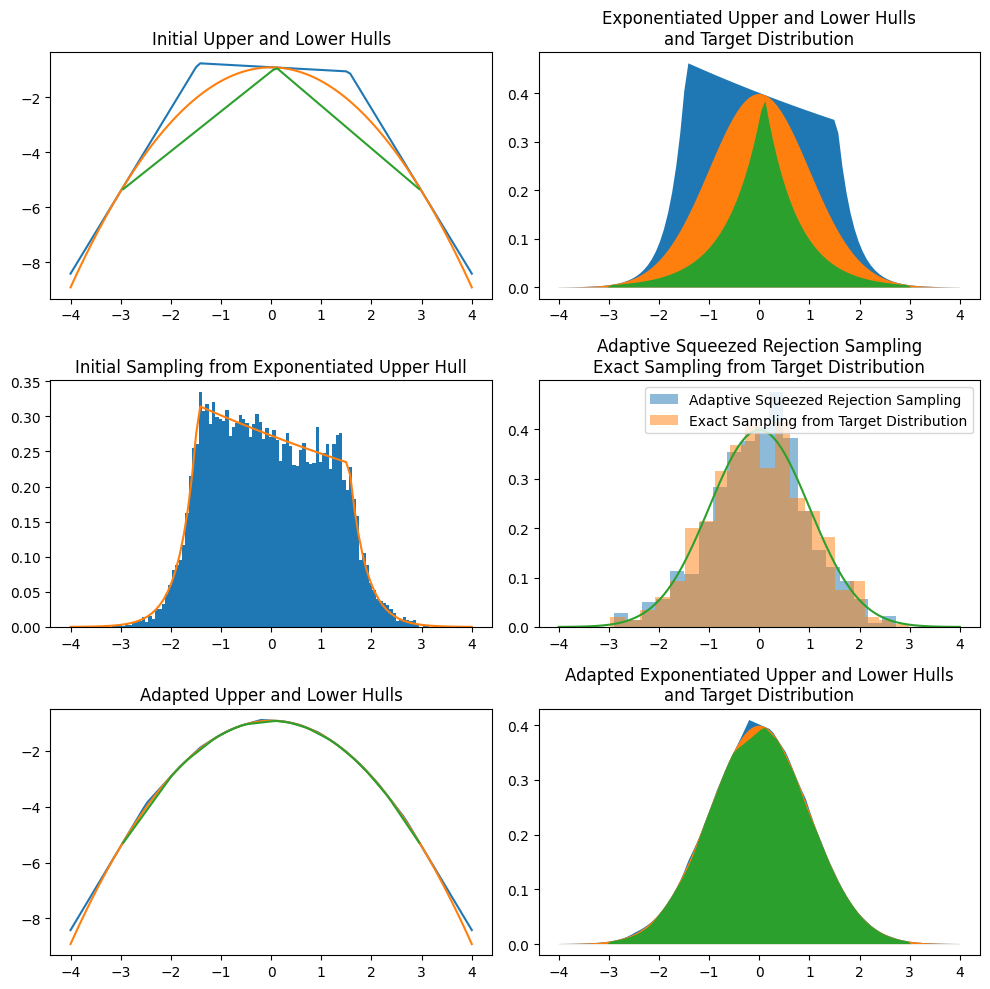

In [6]:
mu, sigma=0,1
target = lambda x: stats.norm(loc=mu,scale=sigma).pdf(x)
logpdf = lambda x: stats.norm(loc=mu,scale=sigma).logpdf(x)
scoref = lambda x: -(x-0)/sigma**2 
xk = np.array([-3., .1, 3.])

ASRS = AdaptiveSqueezedRejectionSampling(target, logpdf, scoref, xk)

fig,ax = plt.subplots(3, 2, figsize=(10,10))
support = np.linspace(-4,4,100)

ax[0,0].plot(support, ASRS.UpperHull(support))
ax[0,0].plot(support, ASRS.logpdf(support))
ax[0,0].plot(support, ASRS.LowerHull(support))
ax[0,0].set_title("Initial Upper and Lower Hulls")

ax[0,1].fill_between(support, 0, np.exp(ASRS.UpperHull(support)))
ax[0,1].fill_between(support, 0, ASRS.target(support))
ax[0,1].fill_between(support, 0, np.exp(ASRS.LowerHull(support)))
ax[0,1].set_title("Exponentiated Upper and Lower Hulls\nand Target Distribution")

ax[1,0].hist(ASRS.SampleFromPiecewiseExponentiatedUpperHull(10000), bins=100, density=True)
c = ASRS.ExponentiatedUpperHullIntervalAreas().sum()
ax[1,0].plot(support, np.exp(ASRS.UpperHull(support))/c)
ax[1,0].set_title("Initial Sampling from Exponentiated Upper Hull")

np.random.seed(501)
n = 500
ax[1,1].hist([ASRS.AdaptiveSqueezedRejectionSample() for i in range(n)], 
             density=True, bins=20, alpha=0.5, label="Adaptive Squeezed Rejection Sampling")
ax[1,1].set_title("Adaptive Squeezed Rejection Sampling\nExact Sampling from Target Distribution")
ax[1,1].hist(stats.norm.rvs(size=n), density=True, bins=20, alpha=0.5,
            label="Exact Sampling from Target Distribution")
ax[1,1].plot(support, ASRS.target(support))
ax[1,1].legend()

ax[2,0].plot(support, ASRS.UpperHull(support))
ax[2,0].plot(support, ASRS.logpdf(support))
ax[2,0].plot(support, ASRS.LowerHull(support))
ax[2,0].set_title("Adapted Upper and Lower Hulls")

ax[2,1].fill_between(support, 0, np.exp(ASRS.UpperHull(support)))
ax[2,1].fill_between(support, 0, ASRS.target(support))
ax[2,1].fill_between(support, 0, np.exp(ASRS.LowerHull(support)))
ax[2,1].set_title("Adapted Exponentiated Upper and Lower Hulls\nand Target Distribution")

plt.tight_layout()